
# Лабораторная работа 1

Классификация `spam.csv`-
  по тексту SMS определить, спам это или нормальное сообщение. Задача реалистичная и может помочь освободить сообщения от лишней ненужной информации.

Регрессия `rating.csv` `movie.csv` -
  по году выпуска и жанрам фильма попытаться предсказать рейтинг, который ставят пользователи. Задача может помочь режиссерам и маркетологам решить, какой фильм снять, чтобы подняться в рейтинге или заработать побольше денег.
  Чтобы не убить Colab, беру только первые 50 000 строк рейтингов

Импорт библиотек

подключаю все библиотеки которые нужны для лабораторной работы. NumPy и pandas помогают работать с данными, а matplotlib и seaborn нужны для построения графиков.

In [ ]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer



## Выбор метрик

### Классификация (спам / не спам)

Класс spam (спам) обычно меньше, чем ham (не спам), поэтому accuracy мало  
Использую такие метрики по классу spam:

- Accuracy - доля правильно классифицированных сообщений
- Precision - из всех найденных моделью спам‑сообщений, сколько реально из них попало, то есть реальный спам  
- Recall - из всех настоящих спамов, сколько модель нашла успешно
- F1 - баланс между precision и recall. я считаю, что это основная метрика для сравнения моделей тут

### Регрессия (рейтинг фильма)

Цель — предсказать числовой рейтинг (0.5–5.0) (в реальности были бы пол звезды и 5 звезд), поэтому беру:

- MAE (Mean Absolute Error) - средняя абсолютная ошибка, легко интерпретируется.  
- RMSE - корень из MSE (чем сильнее промах, тем еще больше будет штраф)  
- R² - доля объяснённой дисперсии (чем ближе к 1, тем лучше).


### Классификация SMS


загружаю датасет со спам сообщениями и оставляю только два нужных столбца: метку сообщения и сам текст

In [ ]:
spam_path = "/content/spam.csv"
spam_df = pd.read_csv(spam_path, encoding="latin1")[["v1", "v2"]]
spam_df.columns = ["label", "message"]
print("Размер датасета:", spam_df.shape)
display(spam_df.head())
print("\nРаспределение классов:")
print(spam_df["label"].value_counts())


Размер датасета: (5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."



Распределение классов:
label
ham     4825
spam     747
Name: count, dtype: int64


В этом блоке я разделяю сообщения на признаки и метки, а затем делю данные на обучающую и тестовую выборки

In [ ]:

# разделяем на обучающую и тестовую выборки

X = spam_df["message"]
y = spam_df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Обучающая выборка:", len(X_train))
print("Тестовая выборка:", len(X_test))


Обучающая выборка: 4457
Тестовая выборка: 1115


Создаю базовую модель для классификации спама. Сначала текст переводится в числовой вид с помощью TF-IDF, затем применяется алгоритм KNN. После обучения я предсказываю метки на тестовых данных и считаю метрики: accuracy, precision, recall и F1

бейзлайн

=== Базовая модель KNN (спам) ===
Accuracy : 0.9121
Precision: 1.0000
Recall   : 0.3423
F1 (spam): 0.5100

              precision    recall  f1-score   support

         ham       0.91      1.00      0.95       966
        spam       1.00      0.34      0.51       149

    accuracy                           0.91      1115
   macro avg       0.95      0.67      0.73      1115
weighted avg       0.92      0.91      0.89      1115



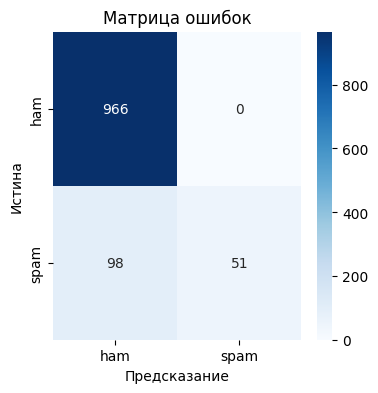

In [ ]:

baseline_clf = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("knn", KNeighborsClassifier())
])

baseline_clf.fit(X_train, y_train)
y_pred_base = baseline_clf.predict(X_test)

acc_base = accuracy_score(y_test, y_pred_base)
prec_base = precision_score(y_test, y_pred_base, pos_label="spam")
rec_base = recall_score(y_test, y_pred_base, pos_label="spam")
f1_base = f1_score(y_test, y_pred_base, pos_label="spam")

print("=== Базовая модель KNN (спам) ===")
print(f"Accuracy : {acc_base:.4f}")
print(f"Precision: {prec_base:.4f}")
print(f"Recall   : {rec_base:.4f}")
print(f"F1 (spam): {f1_base:.4f}\n")
print(classification_report(y_test, y_pred_base))

cm_base = confusion_matrix(y_test, y_pred_base, labels=["ham", "spam"])
plt.figure(figsize=(4,4))
sns.heatmap(cm_base, annot=True, fmt="d", cmap="Blues",
            xticklabels=["ham","spam"], yticklabels=["ham","spam"])
plt.xlabel("Предсказание")
plt.ylabel("Истина")
plt.title("Матрица ошибок")
plt.show()



### Улучшенный KNN

### Гипотезы как можно улучшить модели:

- добавить биграммы ngram_range=(1,2), так как в спаме часто встречаются устойчивые фразы

- убрать слишком редкие слова с помощью min_df, чтобы снизить шум

- подобрать оптимальное число соседей n_neighbors

- использовать взвешивание расстояний weights="distance"

Чтобы не ждать по полчаса, сетку делаю небольшой


создаю конвейер из TF-IDF и KNN и задаю набор параметров которые хочу перебрать. GridSearchCV перебирает все комбинации и с помощью кросс-валидации ищет те которые дают лучший F1

In [ ]:

from sklearn.model_selection import GridSearchCV

pipeline_clf = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("knn", KNeighborsClassifier())
])

param_grid_clf = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 3],
    "knn__n_neighbors": [3, 5],
    "knn__weights": ["uniform", "distance"]
}

grid_clf = GridSearchCV(
    pipeline_clf,
    param_grid_clf,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

grid_clf.fit(X_train, y_train)

print("Лучшие параметры:", grid_clf.best_params_)
print("Лучший средний F1 (cv):", grid_clf.best_score_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Лучшие параметры: {'knn__n_neighbors': 3, 'knn__weights': 'distance', 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)}
Лучший средний F1 (cv): 0.8295228786573738


беру лучшую модель KNN из GridSearchCV и тестирую её на отложенной выборке и смотрю улучшились ли результаты

=== Улучшенная модель KNN (спам) ===
Accuracy : 0.9498
Precision: 0.9895
Recall   : 0.6309
F1 (spam): 0.7705

              precision    recall  f1-score   support

         ham       0.95      1.00      0.97       966
        spam       0.99      0.63      0.77       149

    accuracy                           0.95      1115
   macro avg       0.97      0.81      0.87      1115
weighted avg       0.95      0.95      0.94      1115



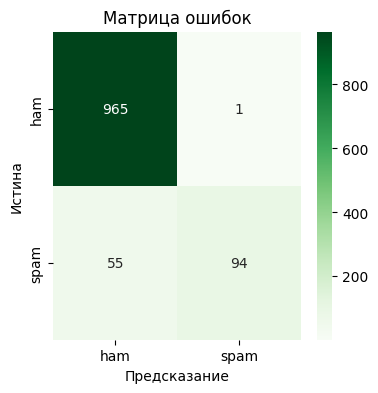

Сравнение базовой и улучшенной моделей:


,model,accuracy,precision_spam,recall_spam,f1_spam
0,baseline,0.912108,1.000000,0.342282,0.510000
1,improved,0.949776,0.989474,0.630872,0.770492


In [ ]:

best_clf = grid_clf.best_estimator_
y_pred_best = best_clf.predict(X_test)

acc_best = accuracy_score(y_test, y_pred_best)
prec_best = precision_score(y_test, y_pred_best, pos_label="spam")
rec_best = recall_score(y_test, y_pred_best, pos_label="spam")
f1_best = f1_score(y_test, y_pred_best, pos_label="spam")

print("=== Улучшенная модель KNN (спам) ===")
print(f"Accuracy : {acc_best:.4f}")
print(f"Precision: {prec_best:.4f}")
print(f"Recall   : {rec_best:.4f}")
print(f"F1 (spam): {f1_best:.4f}\n")
print(classification_report(y_test, y_pred_best))

cm_best = confusion_matrix(y_test, y_pred_best, labels=["ham", "spam"])
plt.figure(figsize=(4,4))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Greens",
            xticklabels=["ham","spam"], yticklabels=["ham","spam"])
plt.xlabel("Предсказание")
plt.ylabel("Истина")
plt.title("Матрица ошибок")
plt.show()

comp_clf = pd.DataFrame({
    "model": ["baseline", "improved"],
    "accuracy": [acc_base, acc_best],
    "precision_spam": [prec_base, prec_best],
    "recall_spam": [rec_base, rec_best],
    "f1_spam": [f1_base, f1_best]
})
print("Сравнение базовой и улучшенной моделей:")
display(comp_clf)


---
## Регрессия: предсказание рейтинга фильма


загружаю таблицу с рейтингами и таблицу с информацией о фильмах. Чтобы ускорить работу беру только 50 тысяч оценок. Потом объединяю две таблицы по movieId чтобы у каждой оценки появились данные о самом фильме

In [ ]:

# загрузка и объединение данных

ratings_path = "/content/rating.csv"
movies_path = "/content/movie.csv"

# 50k строк
ratings_df = pd.read_csv(ratings_path, nrows=50000)
movies_df = pd.read_csv(movies_path)

print("Размер ratings:", ratings_df.shape)
print("Размер movies:", movies_df.shape)

data_ml = ratings_df.merge(movies_df, on="movieId", how="left")
print("Размер объединённой таблицы:", data_ml.shape)
display(data_ml.head())


Размер ratings: (50000, 4)
Размер movies: (27278, 3)
Размер объединённой таблицы: (50000, 6)


,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,3.5,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


Сначала с помощью регулярного выражения я вытаскиваю год из названия фильма. Если года нет то строка удаляется. Затем я превращаю строку с жанрами в список жанров и кодирую их в набор бинарных признаков через multilabelbinizer

In [ ]:

# год и жанр

import re
import numpy as np

def extract_year(title):
    if isinstance(title, str):
        m = re.search(r"(19\d{2}|20\d{2})", title)
        if m:
            return int(m.group(0))
    return np.nan

data_ml["year"] = data_ml["title"].apply(extract_year)
data_ml = data_ml.dropna(subset=["year"])

# жанры в список
data_ml["genres_list"] = data_ml["genres"].fillna("(no genres listed)").apply(lambda s: s.split("|"))

mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(data_ml["genres_list"])
genres_df = pd.DataFrame(genres_encoded, columns=[f"genre_{g}" for g in mlb.classes_])

features_ml = pd.concat(
    [data_ml[["rating", "year"]].reset_index(drop=True),
     genres_df.reset_index(drop=True)],
    axis=1
)

print("Размер таблицы признаков:", features_ml.shape)
display(features_ml.head())


Размер таблицы признаков: (50000, 21)


,rating,year,genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,genre_Film-Noir,genre_Horror,genre_IMAX,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,3.5,1995,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.5,1995,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
2,3.5,1995,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
3,3.5,1995,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,3.5,1995,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0


делю данные на признаки и целевую переменную рейтинг фильма. Затем с помощью train_test_split разделяю их на обучающую и тестовую выборки

In [ ]:

# разделяем на обучающую и тестовую выборки

X_reg = features_ml.drop(columns=["rating"])
y_reg = features_ml["rating"]

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print("train:", X_reg_train.shape)
print("test :", X_reg_test.shape)


train: (40000, 20)
test : (10000, 20)


### 3.4. Базовый KNN для регрессии

обучаю базовую модель KNN для регрессии чтобы предсказывать рейтинги фильмов. После обучения я получаю прогнозы на тестовых данных и считаю метрики MAE RMSE и R² чтобы оценить качество модели и так же строю график с истинными и предсказанными значениями.

=== Базовая модель KNN (регрессия) ===
MAE : 0.8360
RMSE: 1.0692
R^2 : -0.0196


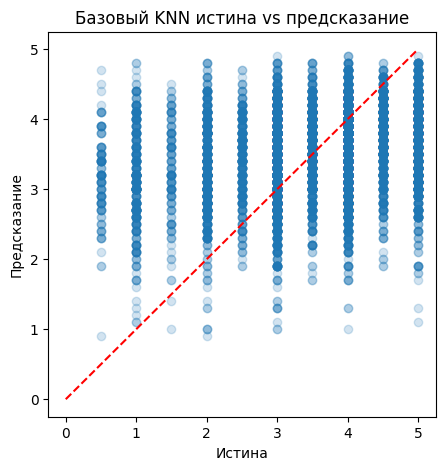

In [ ]:

knn_reg_base = KNeighborsRegressor()
knn_reg_base.fit(X_reg_train, y_reg_train)
y_reg_pred_base = knn_reg_base.predict(X_reg_test)

mae_base = mean_absolute_error(y_reg_test, y_reg_pred_base)
rmse_base = mean_squared_error(y_reg_test, y_reg_pred_base) ** 0.5  # без squared=False
r2_base = r2_score(y_reg_test, y_reg_pred_base)

print("=== Базовая модель KNN (регрессия) ===")
print(f"MAE : {mae_base:.4f}")
print(f"RMSE: {rmse_base:.4f}")
print(f"R^2 : {r2_base:.4f}")

plt.figure(figsize=(5,5))
plt.scatter(y_reg_test, y_reg_pred_base, alpha=0.2)
plt.xlabel("Истина")
plt.ylabel("Предсказание")
plt.title("Базовый KNN истина vs предсказание")
plt.plot([0,5],[0,5],"--",color="red")
plt.show()


### Улучшенный KNN для регрессии

создаю конвейер который сначала масштабирует данные а потом применяет KNN регрессию. Затем задаю небольшую сетку параметров и использую GridSearchCV чтобы перебрать варианты и найти тот который дает наименьшую ошибку MAE

In [ ]:

# масштабирование + KNN
reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor())
])

# сетка маленькая чтобы быстро считалось
param_grid_reg = {
    "knn__n_neighbors": [5, 10],
    "knn__weights": ["uniform", "distance"]
}

grid_reg = GridSearchCV(
    reg_pipeline,
    param_grid_reg,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

grid_reg.fit(X_reg_train, y_reg_train)

print("Лучшие параметры:", grid_reg.best_params_)
print("Лучший MAE (cv):", -grid_reg.best_score_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Лучшие параметры: {'knn__n_neighbors': 10, 'knn__weights': 'uniform'}
Лучший MAE (cv): 0.815590110579223


Беру лучшую модель KNN из GridSearchCV и делаю предсказания на тестовой выборке. После этого считаю метрики MAE RMSE и R² чтобы сравнить качество с базовой моделью

=== Улучшенная модель KNN (регрессия) ===
MAE : 0.8051
RMSE: 1.0312
R^2 : 0.0516


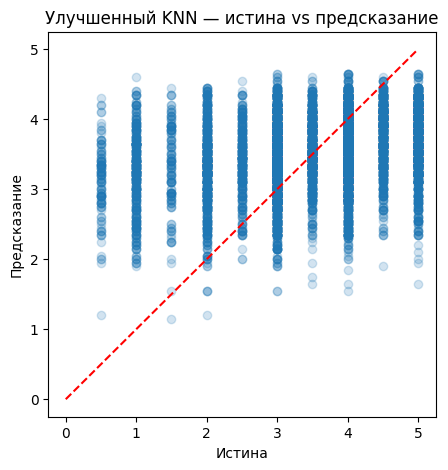

Сравнение моделей:


,model,MAE,RMSE,R2
0,baseline,0.83601,1.069195,-0.019598
1,improved,0.80511,1.031165,0.051644


In [ ]:

best_reg = grid_reg.best_estimator_
y_reg_pred_best = best_reg.predict(X_reg_test)

mae_best = mean_absolute_error(y_reg_test, y_reg_pred_best)
rmse_best = mean_squared_error(y_reg_test, y_reg_pred_best) ** 0.5
r2_best = r2_score(y_reg_test, y_reg_pred_best)

print("=== Улучшенная модель KNN (регрессия) ===")
print(f"MAE : {mae_best:.4f}")
print(f"RMSE: {rmse_best:.4f}")
print(f"R^2 : {r2_best:.4f}")

plt.figure(figsize=(5,5))
plt.scatter(y_reg_test, y_reg_pred_best, alpha=0.2)
plt.xlabel("Истина")
plt.ylabel("Предсказание")
plt.title("Улучшенный KNN — истина vs предсказание")
plt.plot([0,5],[0,5],"--",color="red")
plt.show()

comp_reg = pd.DataFrame({
    "model": ["baseline", "improved"],
    "MAE": [mae_base, mae_best],
    "RMSE": [rmse_base, rmse_best],
    "R2": [r2_base, r2_best]
})
print("Сравнение моделей:")
display(comp_reg)



---
## Самостоятельная реализация

Здесь я попытался написать простой класс `MyKNN`, который умеет и классификацию, и регрессию.  
Реализация не сильно хорошо работает, но показывает как-то работу алгоритмов


В этом блоке я реализую свой собственный алгоритм KNN. В конструкторе задаю количество соседей и тип: классификация или регрессия. В методе fit я просто сохраняю обучающие данные потому что KNN не строит модель а запоминает выборку

In [ ]:

from collections import Counter

class MyKNN:
    def __init__(self, n_neighbors=5, task="classification"):
        self.n_neighbors = n_neighbors
        self.task = task  # 'classification' или 'regression'

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self

    def _predict_one(self, x):
        # расстояние между двумя точками в евклидовом пространстве, то есть длина отрезка прямой соединяющей эти точки
        dists = np.linalg.norm(self.X_train - x, axis=1)
        idx = np.argsort(dists)[:self.n_neighbors]
        neigh = self.y_train[idx]
        if self.task == "classification":
            return Counter(neigh).most_common(1)[0][0]
        else:
            return neigh.mean()

    def predict(self, X):
        X = np.array(X)
        return np.array([self._predict_one(x) for x in X])


Проверяю как работает моя собственная реализация KNN в задаче классификации спама. Сначала я беру TF-IDF из лучшей sklearn модели и преобразую обучающие и тестовые тексты в числовой вид. Так как мой самописный KNN не умеет работать с разреженными матрицами, я перевожу данные в обычные массивы

In [ ]:

# сравнение на классификации спама

# тут берём обученный TF-IDF из лучшей sklearn модели
tfidf_best = best_clf.named_steps["tfidf"]
X_train_vec = tfidf_best.transform(X_train)
X_test_vec = tfidf_best.transform(X_test)

# переведём в массивы так как свой KNN не умеет sparseить
X_train_arr = X_train_vec.toarray()
X_test_arr = X_test_vec.toarray()

my_knn_clf = MyKNN(
    n_neighbors=grid_clf.best_params_["knn__n_neighbors"],
    task="classification"
)
my_knn_clf.fit(X_train_arr, y_train.values)

y_pred_my = my_knn_clf.predict(X_test_arr)

acc_my = accuracy_score(y_test, y_pred_my)
prec_my = precision_score(y_test, y_pred_my, pos_label="spam")
rec_my = recall_score(y_test, y_pred_my, pos_label="spam")
f1_my = f1_score(y_test, y_pred_my, pos_label="spam")

print("=== Мой KNN (классификация) ===")
print(f"Accuracy : {acc_my:.4f}")
print(f"Precision: {prec_my:.4f}")
print(f"Recall   : {rec_my:.4f}")
print(f"F1 (spam): {f1_my:.4f}")

comp_my_clf = pd.DataFrame({
    "model": ["sklearn_improved", "my_knn"],
    "accuracy": [acc_best, acc_my],
    "precision_spam": [prec_best, prec_my],
    "recall_spam": [rec_best, rec_my],
    "f1_spam": [f1_best, f1_my]
})
print("Сравнение sklearn vs мой KNN (классификация):")
display(comp_my_clf)


=== Мой KNN (классификация) ===
Accuracy : 0.9345
Precision: 0.9872
Recall   : 0.5168
F1 (spam): 0.6784
Сравнение sklearn vs мой KNN (классификация):


,model,accuracy,precision_spam,recall_spam,f1_spam
0,sklearn_improved,0.949776,0.989474,0.630872,0.770492
1,my_knn,0.934529,0.987179,0.516779,0.678414


В этом блоке я проверяю насколько хорошо работает моя реализация KNN уже в задаче регрессии. Сначала я беру масштабирование из лучшей sklearn модели и применяю его к обучающим и тестовым данным потому что мой KNN чувствителен к разным масштабам признаков.

После этого обучаю свой KNN на масштабированных данных и делаю предсказания. Затем считаю ошибки MAE, RMSE и коэффициент R² чтобы оценить качество модели.

In [ ]:

# сравнение на регрессии

# берём скейлер из лучшей регрессионной модели
scaler_best = best_reg.named_steps["scaler"]
X_reg_train_scaled = scaler_best.transform(X_reg_train)
X_reg_test_scaled = scaler_best.transform(X_reg_test)

my_knn_reg = MyKNN(
    n_neighbors=grid_reg.best_params_["knn__n_neighbors"],
    task="regression"
)
my_knn_reg.fit(X_reg_train_scaled, y_reg_train.values)

y_reg_pred_my = my_knn_reg.predict(X_reg_test_scaled)

mae_my = mean_absolute_error(y_reg_test, y_reg_pred_my)
rmse_my = mean_squared_error(y_reg_test, y_reg_pred_my) ** 0.5
r2_my = r2_score(y_reg_test, y_reg_pred_my)

print("=== Мой KNN (регрессия) ===")
print(f"MAE : {mae_my:.4f}")
print(f"RMSE: {rmse_my:.4f}")
print(f"R^2 : {r2_my:.4f}")

comp_my_reg = pd.DataFrame({
    "model": ["sklearn_improved", "my_knn"],
    "MAE": [mae_best, mae_my],
    "RMSE": [rmse_best, rmse_my],
    "R2": [r2_best, r2_my]
})
print("Сравнение sklearn vs мой KNN (регрессия):")
display(comp_my_reg)


=== Мой KNN (регрессия) ===
MAE : 0.8071
RMSE: 1.0301
R^2 : 0.0536
Сравнение sklearn vs мой KNN (регрессия):


,model,MAE,RMSE,R2
0,sklearn_improved,0.805110,1.031165,0.051644
1,my_knn,0.807135,1.030092,0.053616



---
## Вывод
В этой работе я попробовал применить алгоритм KNN для двух задач: классификации спама и предсказания рейтингов фильмов. Сначала я сделал базовые модели, и оказалось, что без настройки они показывают средние результаты, особенно в классификации. После подбора параметров и небольшой обработки данных качество стало заметно лучше и модель начала лучше находить спам, а ошибки в регрессии уменьшились. Затем я реализовал свой вариант KNN и сравнил его со sklearn и в целом он работает правильно, но точность немного хуже, что ожидаемо. В итоге я понял, как сильно на knn влияет подготовка данных.